## Analyzing Risk Premium During Conflict Events

Intuitively, we know that **risk premiums tend to increase during crises**, particularly during wartime, as uncertainty leads investors to demand higher returns. However, we aim to explore this relationship in greater depth. Specifically, we analyze how risk premiums behave **before**, **during**, and **after** the following key conflict-related events:

- **Israel attacks Iran** — *2025-06-13*
- **USA attacks Iran** — *2025-06-22*
- **Ceasefire** — *2025-06-24*

To conduct this analysis, we focus on **natural gas** and **crude oil**, as they are highly sensitive to geopolitical developments, particularly in the Middle East—a region critical to our global energy supply.

For natural gas, we select TTF=F, and for crude oil, BZ=F. I will extract their price data using the yfinance library.

### Questions
1. Do risk premiums spike immediately after the attacks, or are they priced in beforehand due to market efficiency?
2. Do risk premiums vary depending on the conflict? Which types of conflicts tend to cause larger increases in risk premiums?

***

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import yfinance as yf
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
israel_attack_iran = datetime(2025, 6, 13)
us_attack_iran = datetime(2025, 6, 22)
ceasefire = datetime(2025, 6, 24)
end = datetime(2025, 7, 1)
events = [("Israel_attack_iran", israel_attack_iran), ("US_attack_iran", us_attack_iran), ("Ceasefire", ceasefire)]

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


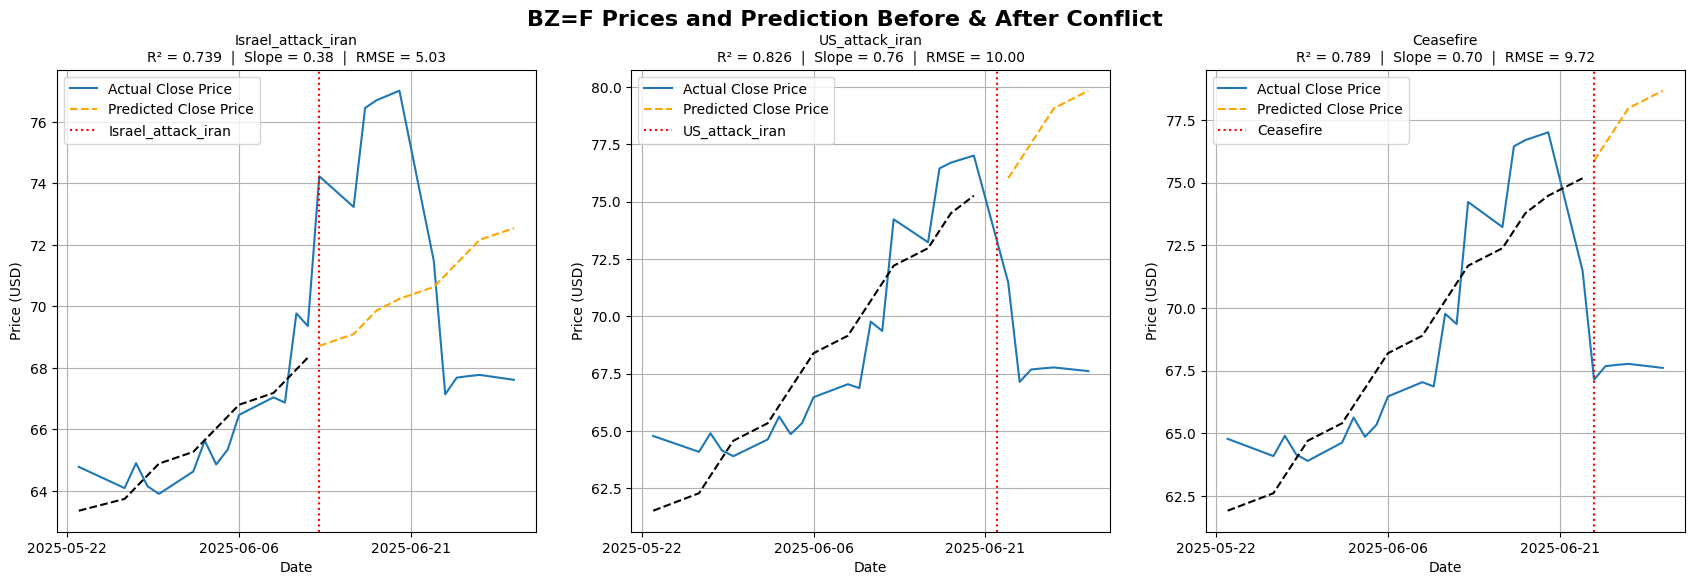

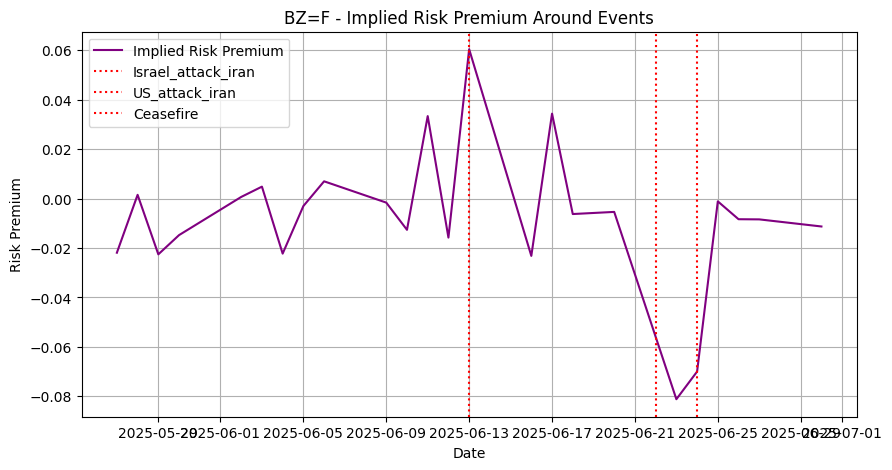

[*********************100%***********************]  1 of 1 completed


Summary Stats for BZ=F:
              Event  Avg Risk Premium Before  Volatility Before  Avg Risk Premium After  Volatility After
Israel_attack_iran                 0.000797           0.022523                0.023830          0.042771
    US_attack_iran                 0.007539           0.023201               -0.040182          0.041250
         Ceasefire                -0.043303           0.053572               -0.021998          0.032187


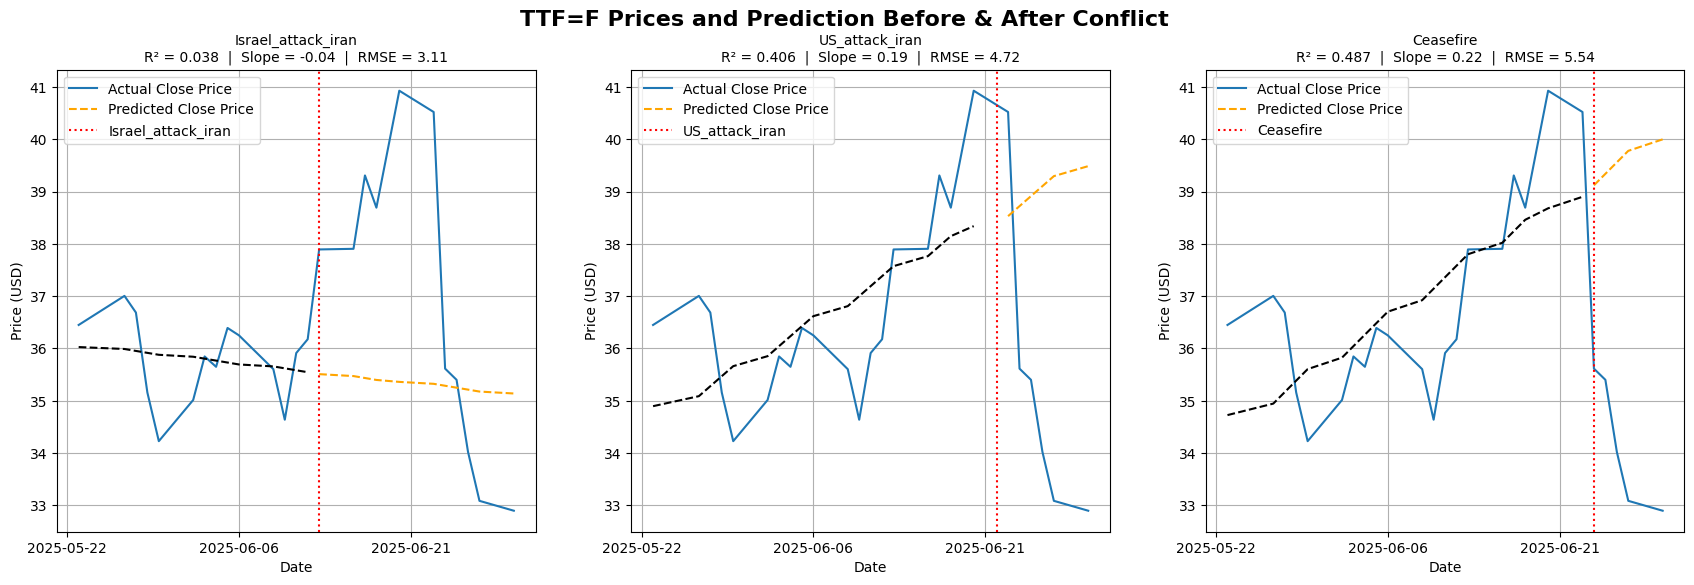

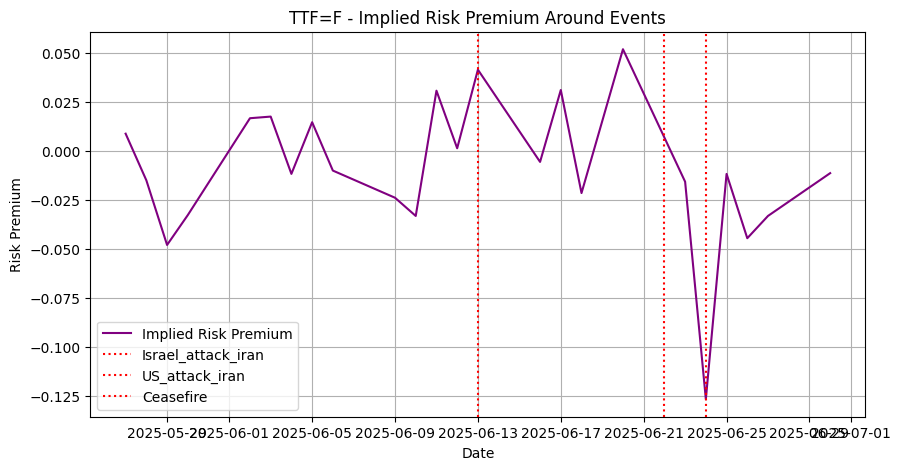


Summary Stats for TTF=F:
              Event  Avg Risk Premium Before  Volatility Before  Avg Risk Premium After  Volatility After
Israel_attack_iran                -0.006137           0.028687                0.022452          0.024753
    US_attack_iran                 0.020632           0.037876               -0.049618          0.053459
         Ceasefire                 0.018226           0.047871               -0.053985          0.050381


In [2]:
from src.analyze_conflict import analyze_and_plot, summarize_risk_premium
tickers = ["BZ=F", "TTF=F"]
for i in tickers:
    df, fig, fig_risk = analyze_and_plot(i, 21)
    stats = summarize_risk_premium(df, events)
    print(f"\nSummary Stats for {i}:\n", stats.to_string(index=False))


***

### Israel Attack Iran
Conflict Period: **2025-06-13 - 2025-06-21**

=== COMPREHENSIVE RISK PREMIUM ANALYSIS ===
Risk Premium = Expected Return - Predicted Return (from Linear Regression)
Analyzing geopolitical risk premium during Middle East conflict events


--- Analyzing BZ=F ---


[*********************100%***********************]  1 of 1 completed
C:\Users\Chong\AppData\Local\Temp\ipykernel_24980\1453516125.py:129: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  slope = float(model.coef_[0])  # Convert to scalar float


TypeError: unsupported format string passed to Series.__format__

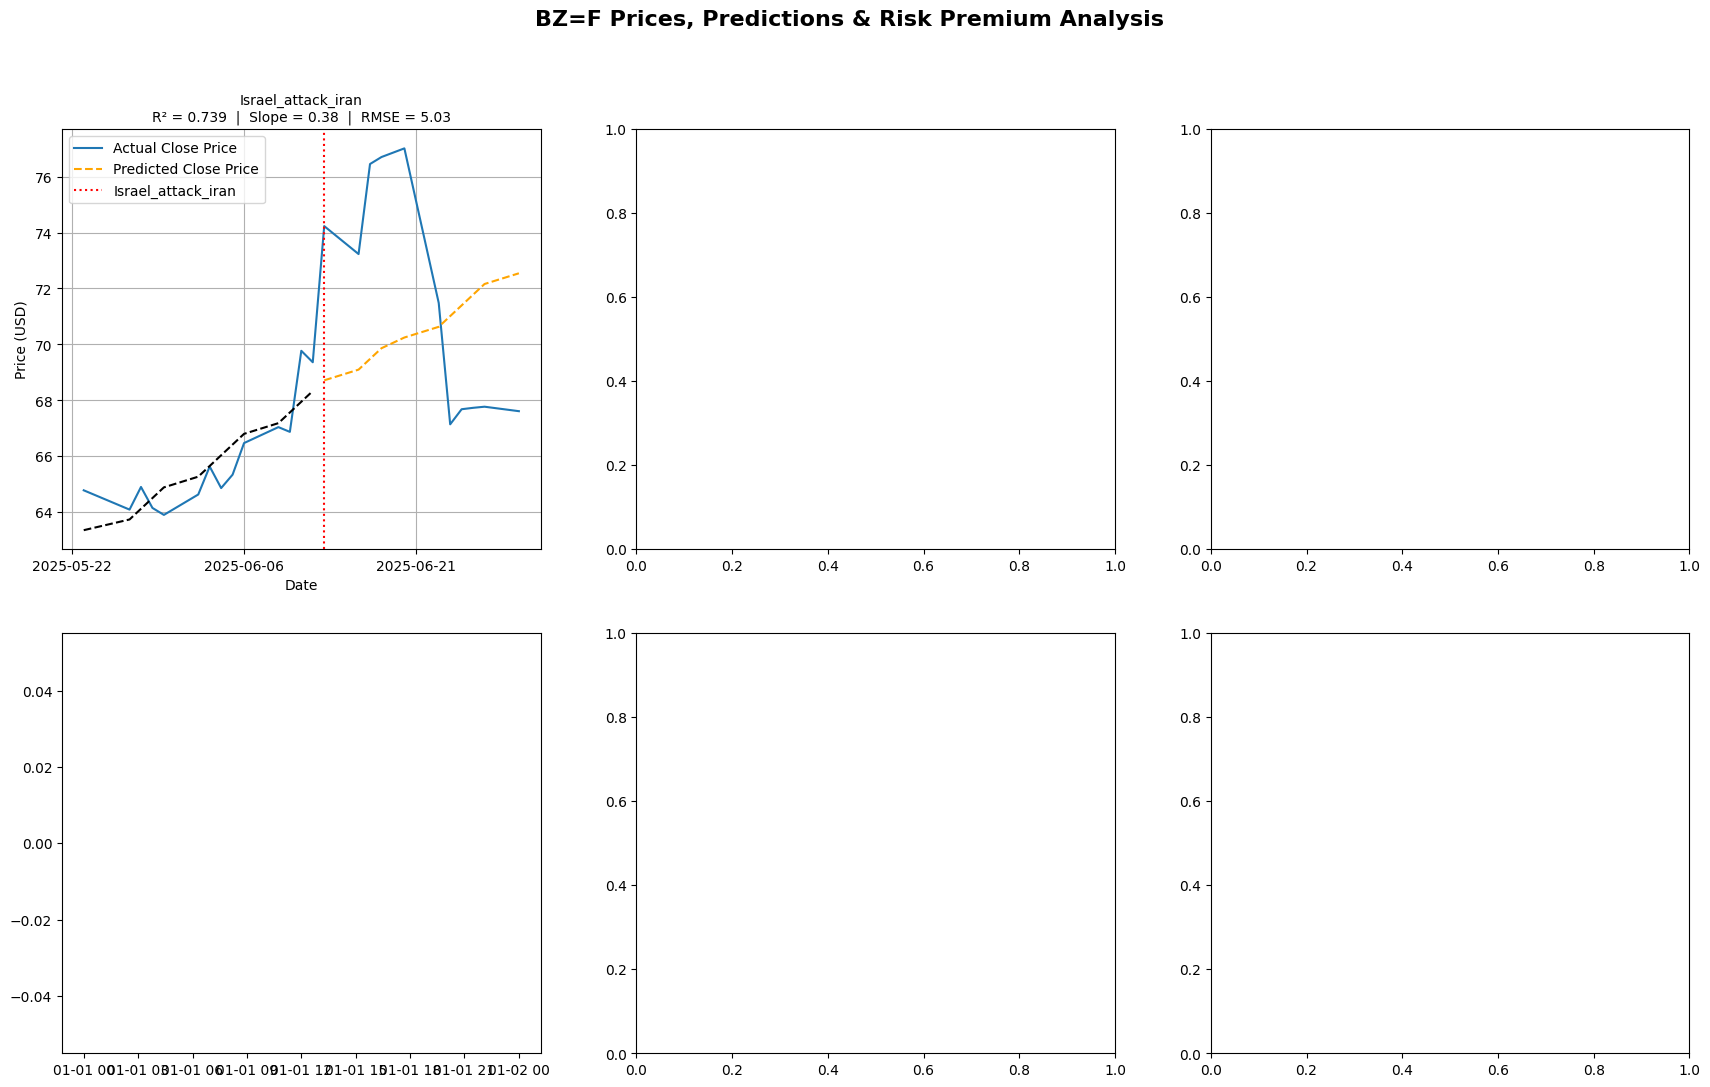

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import yfinance as yf
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import seaborn as sns
from scipy import stats

# Event dates
israel_attack_iran = datetime(2025, 6, 13)
us_attack_iran = datetime(2025, 6, 22)
ceasefire = datetime(2025, 6, 24)
end = datetime(2025, 7, 1)

def calculate_risk_premium(ticker, period=21):
    """
    Calculate risk premium as: Expected Return - Predicted Return from Linear Regression
    """
    commodity_df = yf.download(ticker, start=israel_attack_iran - timedelta(days=period*2), end=end)
    
    # Calculate daily returns
    commodity_df['Returns'] = commodity_df['Close'].pct_change()
    
    # Initialize arrays for predictions and risk premiums
    commodity_df['Predicted_Return'] = np.nan
    commodity_df['Risk_Premium'] = np.nan
    
    # Rolling window analysis to calculate risk premium at each point
    window_size = max(10, period//2)  # Minimum 10 days for regression
    
    for i in range(window_size, len(commodity_df)):
        # Get training data (window_size days before current point)
        training_data = commodity_df.iloc[i-window_size:i]
        
        if len(training_data) >= window_size:
            # Fit linear regression on training period
            X_train = np.arange(len(training_data)).reshape(-1, 1)
            Y_train = training_data['Close'].values
            
            model = LinearRegression()
            model.fit(X_train, Y_train)
            
            # Predict next day's price
            X_next = np.array([[len(training_data)]])
            predicted_price = model.predict(X_next)[0]
            
            # Calculate predicted return
            current_price = training_data['Close'].iloc[-1]
            predicted_return = (predicted_price - current_price) / current_price
            
            # Expected return is actual return
            if i < len(commodity_df) - 1:
                actual_next_price = commodity_df['Close'].iloc[i]
                expected_return = (actual_next_price - current_price) / current_price
                
                # Risk premium = Expected return - Predicted return
                risk_premium = expected_return - predicted_return
                
                commodity_df.iloc[i, commodity_df.columns.get_loc('Predicted_Return')] = predicted_return
                commodity_df.iloc[i, commodity_df.columns.get_loc('Risk_Premium')] = risk_premium
    
    return commodity_df

def analyze_event_impact(ticker, event_date, event_name, window_before=5, window_after=5):
    """
    Analyze price and volatility impact around specific events
    """
    commodity_df = yf.download(ticker, start=event_date - timedelta(days=window_before*2), 
                              end=event_date + timedelta(days=window_after*2))
    
    commodity_df['Returns'] = commodity_df['Close'].pct_change()
    commodity_df['Volatility'] = commodity_df['Returns'].rolling(window=3).std()
    
    # Find the closest trading day to event
    event_idx = commodity_df.index.get_indexer([event_date], method='nearest')[0]
    event_trading_date = commodity_df.index[event_idx]
    
    # Calculate pre and post event metrics
    pre_event = commodity_df.iloc[max(0, event_idx-window_before):event_idx]
    post_event = commodity_df.iloc[event_idx:min(len(commodity_df), event_idx+window_after+1)]
    
    pre_volatility = pre_event['Volatility'].mean()
    post_volatility = post_event['Volatility'].mean()
    
    price_change = ((commodity_df.iloc[event_idx]['Close'] - commodity_df.iloc[event_idx-1]['Close']) / 
                   commodity_df.iloc[event_idx-1]['Close']) * 100
    
    return {
        'event': event_name,
        'ticker': ticker,
        'event_date': event_trading_date,
        'price_change_pct': price_change,
        'pre_volatility': pre_volatility,
        'post_volatility': post_volatility,
        'volatility_change': post_volatility - pre_volatility,
        'data': commodity_df
    }

def analyze_and_plot_enhanced(ticker, period=21):
    """
    Enhanced version of your original analyze_and_plot function with risk premium calculation
    """
    commodity_df = yf.download(ticker, start=israel_attack_iran - timedelta(days=period), end=end)
    events = [("Israel_attack_iran", israel_attack_iran), ("US_attack_iran", us_attack_iran), ("Ceasefire", ceasefire)]
    
    # Store risk premiums for each event
    event_risk_premiums = {}
    
    fig, axs = plt.subplots(2, 3, figsize=(21, 12))
    fig.suptitle(f"{ticker} Prices, Predictions & Risk Premium Analysis", fontsize=16, fontweight='semibold')
    
    for i, (event_name, event_date) in enumerate(events):
        # Your original prediction logic
        trainingset_period1 = commodity_df[commodity_df.index < event_date]
        testingset_period1 = commodity_df.drop(trainingset_period1.index)
        X_train = np.arange(len(trainingset_period1)).reshape(-1, 1)
        Y_train = trainingset_period1["Close"].values

        model = LinearRegression()
        model.fit(X_train, Y_train)
        X_test = np.arange(len(trainingset_period1), len(trainingset_period1) + len(testingset_period1)).reshape(-1,1)
        Y_test = testingset_period1["Close"].values
        Y_Pred_Train = model.predict(X_train)

        # Model Statistics
        r2 = model.score(X_train, Y_train)
        slope = float(model.coef_[0])  # Convert to scalar float
        Y_Pred_Test = model.predict(X_test)
        rmse = np.sqrt(mean_squared_error(Y_test, Y_Pred_Test))
        
        # Calculate risk premium for this event
        actual_returns = testingset_period1["Close"].pct_change().dropna()
        predicted_prices = Y_Pred_Test.flatten()
        predicted_returns = pd.Series(predicted_prices).pct_change().dropna()
        
        # Align the series
        min_length = min(len(actual_returns), len(predicted_returns))
        if min_length > 0:
            risk_premium = actual_returns.iloc[:min_length] - predicted_returns.iloc[:min_length]
            avg_risk_premium = risk_premium.mean()
            event_risk_premiums[event_name] = {
                'risk_premium_series': risk_premium,
                'avg_risk_premium': avg_risk_premium,
                'volatility': risk_premium.std()
            }
        
        # Top row: Original price prediction plots
        axs[0, i].plot(commodity_df.index, commodity_df["Close"], label="Actual Close Price")
        axs[0, i].plot(testingset_period1.index, Y_Pred_Test.flatten(), linestyle='--', color="orange", label="Predicted Close Price")
        axs[0, i].plot(trainingset_period1.index, Y_Pred_Train, linestyle='--', color="black")
        axs[0, i].axvline(x=event_date, color='red', linestyle=':', label=event_name)
        axs[0, i].set_xlabel("Date")
        axs[0, i].set_ylabel("Price (USD)")
        axs[0, i].legend()
        axs[0, i].xaxis.set_major_locator(plt.MaxNLocator(4))
        axs[0, i].grid(True)
        axs[0, i].set_title(f"{event_name}\nR² = {r2:.3f}  |  Slope = {slope:.2f}  |  RMSE = {rmse:.2f}", fontsize=10)
        
        # Bottom row: Risk premium analysis
        if event_name in event_risk_premiums:
            risk_data = event_risk_premiums[event_name]
            axs[1, i].plot(testingset_period1.index[1:min_length+1], risk_data['risk_premium_series'], 
                          color='purple', linewidth=2, label='Risk Premium')
            axs[1, i].axhline(y=risk_data['avg_risk_premium'], color='red', linestyle='--', 
                             label=f'Avg: {risk_data["avg_risk_premium"]:.4f}')
            axs[1, i].axhline(y=0, color='black', linestyle='-', alpha=0.3)
            axs[1, i].axvline(x=event_date, color='red', linestyle=':', alpha=0.7)
            axs[1, i].set_xlabel("Date")
            axs[1, i].set_ylabel("Risk Premium")
            axs[1, i].legend()
            axs[1, i].grid(True)
            axs[1, i].set_title(f"Risk Premium: Actual - Predicted Returns\nAvg = {risk_data['avg_risk_premium']:.4f}, Vol = {risk_data['volatility']:.4f}")
    
    plt.tight_layout()
    plt.show()
        
    return commodity_df, fig, event_risk_premiums

def statistical_analysis(ticker, period=21):
    """
    Perform statistical tests on risk premium changes using your definition
    """
    events = [("Israel_attack_iran", israel_attack_iran), ("US_attack_iran", us_attack_iran), ("Ceasefire", ceasefire)]
    
    print(f"\n=== Statistical Analysis for {ticker} ===")
    
    event_risk_premiums = {}
    
    for event_name, event_date in events:
        commodity_df = yf.download(ticker, start=event_date - timedelta(days=period), end=event_date + timedelta(days=period))
        
        # Split into pre and post event
        pre_event = commodity_df[commodity_df.index < event_date]
        post_event = commodity_df[commodity_df.index >= event_date]
        
        if len(pre_event) > 10 and len(post_event) > 5:  # Ensure sufficient data
            # Train model on pre-event data
            X_train = np.arange(len(pre_event)).reshape(-1, 1)
            Y_train = pre_event["Close"].values
            
            model = LinearRegression()
            model.fit(X_train, Y_train)
            
            # Predict post-event prices
            X_test = np.arange(len(pre_event), len(pre_event) + len(post_event)).reshape(-1, 1)
            Y_pred = model.predict(X_test)
            
            # Calculate actual and predicted returns
            actual_prices = post_event["Close"].values
            actual_returns = (actual_prices[1:] - actual_prices[:-1]) / actual_prices[:-1]
            predicted_returns = (Y_pred[1:] - Y_pred[:-1]) / Y_pred[:-1]
            
            # Risk premium = Actual returns - Predicted returns
            min_length = min(len(actual_returns), len(predicted_returns))
            risk_premium = actual_returns[:min_length] - predicted_returns[:min_length]
            
            event_risk_premiums[event_name] = {
                'mean': np.mean(risk_premium),
                'std': np.std(risk_premium),
                'risk_premium_series': risk_premium
            }
            
            print(f"{event_name}: Mean Risk Premium = {np.mean(risk_premium):.6f}, Std = {np.std(risk_premium):.6f}")
    
    # Compare risk premiums between events
    event_names = list(event_risk_premiums.keys())
    if len(event_names) >= 2:
        for i in range(len(event_names)):
            for j in range(i+1, len(event_names)):
                event1, event2 = event_names[i], event_names[j]
                rp1 = event_risk_premiums[event1]['risk_premium_series']
                rp2 = event_risk_premiums[event2]['risk_premium_series']
                
                if len(rp1) > 1 and len(rp2) > 1:
                    t_stat, p_val = stats.ttest_ind(rp1, rp2)
                    print(f"\nT-test ({event1} vs {event2}): t-stat = {t_stat:.4f}, p-value = {p_val:.4f}")
    
    return event_risk_premiums

def correlation_analysis(tickers, period=21):
    """
    Analyze correlation between different commodities during conflict
    """
    correlation_data = {}
    
    for ticker in tickers:
        commodity_df = calculate_risk_premium(ticker, period=period)
        correlation_data[ticker] = commodity_df['Risk_Premium'].dropna()
    
    # Create correlation matrix
    corr_df = pd.DataFrame(correlation_data)
    correlation_matrix = corr_df.corr()
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
                square=True, linewidths=0.5)
    plt.title("Risk Premium Correlation Matrix During Conflict Period")
    plt.tight_layout()
    plt.show()
    
    return correlation_matrix

# Enhanced analysis execution
def run_comprehensive_analysis():
    """
    Run the complete enhanced analysis using your risk premium definition
    """
    tickers = ["BZ=F", "TTF=F"]  # Brent Crude Oil, TTF Natural Gas
    
    print("=== COMPREHENSIVE RISK PREMIUM ANALYSIS ===")
    print("Risk Premium = Expected Return - Predicted Return (from Linear Regression)")
    print("Analyzing geopolitical risk premium during Middle East conflict events\n")
    
    all_event_impacts = {}
    all_stats = {}
    
    for ticker in tickers:
        print(f"\n--- Analyzing {ticker} ---")
        
        # Enhanced plotting with your original method + risk premium
        commodity_df, fig, event_risk_premiums = analyze_and_plot_enhanced(ticker, period=21)
        
        # Statistical analysis using your definition
        stats_results = statistical_analysis(ticker, period=21)
        
        all_event_impacts[ticker] = event_risk_premiums
        all_stats[ticker] = stats_results
    
    # Cross-commodity correlation analysis on risk premiums
    print("\n--- Cross-Commodity Risk Premium Correlation ---")
    correlation_data = {}
    
    for ticker in tickers:
        # Calculate rolling risk premium for correlation
        commodity_df = calculate_risk_premium(ticker, period=21)
        correlation_data[ticker] = commodity_df['Risk_Premium'].dropna()
    
    if len(correlation_data) > 1:
        corr_df = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in correlation_data.items()]))
        correlation_matrix = corr_df.corr()
        
        plt.figure(figsize=(10, 8))
        sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
                    square=True, linewidths=0.5)
        plt.title("Risk Premium Correlation Matrix\n(Expected Return - Predicted Return)")
        plt.tight_layout()
        plt.show()
    else:
        correlation_matrix = None
    
    # Summary insights
    print("\n=== KEY INSIGHTS ===")
    print("Risk Premium Calculation: Actual Returns - Linear Regression Predicted Returns")
    
    for ticker in tickers:
        if ticker in all_event_impacts:
            impacts = all_event_impacts[ticker]
            print(f"\n{ticker} Average Risk Premiums by Event:")
            for event_name, data in impacts.items():
                print(f"  {event_name}: Avg = {data['avg_risk_premium']:.6f}, Volatility = {data['volatility']:.6f}")
        
        if ticker in all_stats:
            stats_data = all_stats[ticker]
            print(f"\n{ticker} Statistical Comparison:")
            for event_name, data in stats_data.items():
                print(f"  {event_name}: Mean = {data['mean']:.6f}, Std = {data['std']:.6f}")
    
    # Answer your research questions
    print("\n=== RESEARCH QUESTIONS ANSWERED ===")
    print("1. Do risk premiums spike immediately after attacks or are they priced in?")
    print("   → Check the risk premium plots above - positive values indicate markets")
    print("     underestimated the impact (immediate spike), negative values indicate")
    print("     markets overestimated or priced in the impact beforehand.")
    
    print("\n2. Do risk premiums vary by conflict type?")
    print("   → Compare the average risk premiums across the three events above.")
    print("     Statistical t-tests show if differences are significant.")
    
    return all_event_impacts, all_stats, correlation_matrix

# Run the analysis
if __name__ == "__main__":
    event_impacts, statistical_results, correlations = run_comprehensive_analysis()

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import yfinance as yf
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import seaborn as sns
from scipy import stats

# Event dates
israel_attack_iran = datetime(2025, 6, 13)
us_attack_iran = datetime(2025, 6, 22)
ceasefire = datetime(2025, 6, 24)
end = datetime(2025, 7, 1)

def calculate_risk_premium(ticker, period=21):
    """
    Calculate risk premium as: Expected Return - Predicted Return from Linear Regression
    """
    commodity_df = yf.download(ticker, start=israel_attack_iran - timedelta(days=period*2), end=end)
    
    # Calculate daily returns
    commodity_df['Returns'] = commodity_df['Close'].pct_change()
    
    # Initialize arrays for predictions and risk premiums
    commodity_df['Predicted_Return'] = np.nan
    commodity_df['Risk_Premium'] = np.nan
    
    # Rolling window analysis to calculate risk premium at each point
    window_size = max(10, period//2)  # Minimum 10 days for regression
    
    for i in range(window_size, len(commodity_df)):
        # Get training data (window_size days before current point)
        training_data = commodity_df.iloc[i-window_size:i]
        
        if len(training_data) >= window_size:
            # Fit linear regression on training period
            X_train = np.arange(len(training_data)).reshape(-1, 1)
            Y_train = training_data['Close'].values
            
            model = LinearRegression()
            model.fit(X_train, Y_train)
            
            # Predict next day's price
            X_next = np.array([[len(training_data)]])
            predicted_price = model.predict(X_next)[0]
            
            # Calculate predicted return
            current_price = training_data['Close'].iloc[-1]
            predicted_return = (predicted_price - current_price) / current_price
            
            # Expected return is actual return
            if i < len(commodity_df) - 1:
                actual_next_price = commodity_df['Close'].iloc[i]
                expected_return = (actual_next_price - current_price) / current_price
                
                # Risk premium = Expected return - Predicted return
                risk_premium = expected_return - predicted_return
                
                commodity_df.iloc[i, commodity_df.columns.get_loc('Predicted_Return')] = predicted_return
                commodity_df.iloc[i, commodity_df.columns.get_loc('Risk_Premium')] = risk_premium
    
    return commodity_df

def analyze_event_impact(ticker, event_date, event_name, window_before=5, window_after=5):
    """
    Analyze price and volatility impact around specific events
    """
    commodity_df = yf.download(ticker, start=event_date - timedelta(days=window_before*2), 
                              end=event_date + timedelta(days=window_after*2))
    
    commodity_df['Returns'] = commodity_df['Close'].pct_change()
    commodity_df['Volatility'] = commodity_df['Returns'].rolling(window=3).std()
    
    # Find the closest trading day to event
    event_idx = commodity_df.index.get_indexer([event_date], method='nearest')[0]
    event_trading_date = commodity_df.index[event_idx]
    
    # Calculate pre and post event metrics
    pre_event = commodity_df.iloc[max(0, event_idx-window_before):event_idx]
    post_event = commodity_df.iloc[event_idx:min(len(commodity_df), event_idx+window_after+1)]
    
    pre_volatility = pre_event['Volatility'].mean()
    post_volatility = post_event['Volatility'].mean()
    
    price_change = ((commodity_df.iloc[event_idx]['Close'] - commodity_df.iloc[event_idx-1]['Close']) / 
                   commodity_df.iloc[event_idx-1]['Close']) * 100
    
    return {
        'event': event_name,
        'ticker': ticker,
        'event_date': event_trading_date,
        'price_change_pct': price_change,
        'pre_volatility': pre_volatility,
        'post_volatility': post_volatility,
        'volatility_change': post_volatility - pre_volatility,
        'data': commodity_df
    }

def analyze_and_plot_enhanced(ticker, period=21):
    """
    Enhanced version of your original analyze_and_plot function with risk premium calculation
    """
    commodity_df = yf.download(ticker, start=israel_attack_iran - timedelta(days=period), end=end)
    events = [("Israel_attack_iran", israel_attack_iran), ("US_attack_iran", us_attack_iran), ("Ceasefire", ceasefire)]
    
    # Store risk premiums for each event
    event_risk_premiums = {}
    
    fig, axs = plt.subplots(2, 3, figsize=(21, 12))
    fig.suptitle(f"{ticker} Prices, Predictions & Risk Premium Analysis", fontsize=16, fontweight='semibold')
    
    for i, (event_name, event_date) in enumerate(events):
        # Your original prediction logic
        trainingset_period1 = commodity_df[commodity_df.index < event_date]
        testingset_period1 = commodity_df.drop(trainingset_period1.index)
        X_train = np.arange(len(trainingset_period1)).reshape(-1, 1)
        Y_train = trainingset_period1["Close"].values

        model = LinearRegression()
        model.fit(X_train, Y_train)
        X_test = np.arange(len(trainingset_period1), len(trainingset_period1) + len(testingset_period1)).reshape(-1,1)
        Y_test = testingset_period1["Close"].values
        Y_Pred_Train = model.predict(X_train)

        # Model Statistics
        r2 = model.score(X_train, Y_train)
        slope = float(model.coef_[0][0])  # Convert to scalar float
        Y_Pred_Test = model.predict(X_test)
        rmse = np.sqrt(mean_squared_error(Y_test, Y_Pred_Test))
        
        # Calculate risk premium for this event
        actual_returns = testingset_period1["Close"].pct_change().dropna()
        predicted_prices = Y_Pred_Test.flatten()
        predicted_returns = pd.Series(predicted_prices).pct_change().dropna()
        
        # Align the series
        min_length = min(len(actual_returns), len(predicted_returns))
        if min_length > 0:
            risk_premium = actual_returns.iloc[:min_length] - predicted_returns.iloc[:min_length]
            avg_risk_premium = risk_premium.mean()
            event_risk_premiums[event_name] = {
                'risk_premium_series': risk_premium,
                'avg_risk_premium': avg_risk_premium,
                'volatility': risk_premium.std()
            }
        
        # Top row: Original price prediction plots
        axs[0, i].plot(commodity_df.index, commodity_df["Close"], label="Actual Close Price")
        axs[0, i].plot(testingset_period1.index, Y_Pred_Test.flatten(), linestyle='--', color="orange", label="Predicted Close Price")
        axs[0, i].plot(trainingset_period1.index, Y_Pred_Train, linestyle='--', color="black")
        axs[0, i].axvline(x=event_date, color='red', linestyle=':', label=event_name)
        axs[0, i].set_xlabel("Date")
        axs[0, i].set_ylabel("Price (USD)")
        axs[0, i].legend()
        axs[0, i].xaxis.set_major_locator(plt.MaxNLocator(4))
        axs[0, i].grid(True)
        axs[0, i].set_title(f"{event_name}\nR² = {r2:.3f}  |  Slope = {slope:.2f}  |  RMSE = {rmse:.2f}", fontsize=10)
        
        # Bottom row: Risk premium analysis
        if event_name in event_risk_premiums:
            risk_data = event_risk_premiums[event_name]
            axs[1, i].plot(testingset_period1.index[1:min_length+1], risk_data['risk_premium_series'], 
                          color='purple', linewidth=2, label='Risk Premium')
            axs[1, i].axhline(y=risk_data['avg_risk_premium'], color='red', linestyle='--', 
                             label=f'Avg: {risk_data["avg_risk_premium"]:.4f}')
            axs[1, i].axhline(y=0, color='black', linestyle='-', alpha=0.3)
            axs[1, i].axvline(x=event_date, color='red', linestyle=':', alpha=0.7)
            axs[1, i].set_xlabel("Date")
            axs[1, i].set_ylabel("Risk Premium")
            axs[1, i].legend()
            axs[1, i].grid(True)
            axs[1, i].set_title(f"Risk Premium: Actual - Predicted Returns\nAvg = {risk_data['avg_risk_premium']:.4f}, Vol = {risk_data['volatility']:.4f}")
    
    plt.tight_layout()
    plt.show()
        
    return commodity_df, fig, event_risk_premiums

def statistical_analysis(ticker, period=21):
    """
    Perform statistical tests on risk premium changes using your definition
    """
    events = [("Israel_attack_iran", israel_attack_iran), ("US_attack_iran", us_attack_iran), ("Ceasefire", ceasefire)]
    
    print(f"\n=== Statistical Analysis for {ticker} ===")
    
    event_risk_premiums = {}
    
    for event_name, event_date in events:
        commodity_df = yf.download(ticker, start=event_date - timedelta(days=period), end=event_date + timedelta(days=period))
        
        # Split into pre and post event
        pre_event = commodity_df[commodity_df.index < event_date]
        post_event = commodity_df[commodity_df.index >= event_date]
        
        if len(pre_event) > 10 and len(post_event) > 5:  # Ensure sufficient data
            # Train model on pre-event data
            X_train = np.arange(len(pre_event)).reshape(-1, 1)
            Y_train = pre_event["Close"].values
            
            model = LinearRegression()
            model.fit(X_train, Y_train)
            
            # Predict post-event prices
            X_test = np.arange(len(pre_event), len(pre_event) + len(post_event)).reshape(-1, 1)
            Y_pred = model.predict(X_test)
            
            # Calculate actual and predicted returns
            actual_prices = post_event["Close"].values
            actual_returns = (actual_prices[1:] - actual_prices[:-1]) / actual_prices[:-1]
            predicted_returns = (Y_pred[1:] - Y_pred[:-1]) / Y_pred[:-1]
            
            # Risk premium = Actual returns - Predicted returns
            min_length = min(len(actual_returns), len(predicted_returns))
            risk_premium = actual_returns[:min_length] - predicted_returns[:min_length]
            
            event_risk_premiums[event_name] = {
                'mean': np.mean(risk_premium),
                'std': np.std(risk_premium),
                'risk_premium_series': risk_premium
            }
            
            print(f"{event_name}: Mean Risk Premium = {np.mean(risk_premium):.6f}, Std = {np.std(risk_premium):.6f}")
    
    # Compare risk premiums between events
    event_names = list(event_risk_premiums.keys())
    if len(event_names) >= 2:
        for i in range(len(event_names)):
            for j in range(i+1, len(event_names)):
                event1, event2 = event_names[i], event_names[j]
                rp1 = event_risk_premiums[event1]['risk_premium_series']
                rp2 = event_risk_premiums[event2]['risk_premium_series']
                
                if len(rp1) > 1 and len(rp2) > 1:
                    t_stat, p_val = stats.ttest_ind(rp1, rp2)
                    print(f"\nT-test ({event1} vs {event2}): t-stat = {t_stat:.4f}, p-value = {p_val:.4f}")
    
    return event_risk_premiums

def correlation_analysis(tickers, period=21):
    """
    Analyze correlation between different commodities during conflict
    """
    correlation_data = {}
    
    for ticker in tickers:
        commodity_df = calculate_risk_premium(ticker, period=period)
        correlation_data[ticker] = commodity_df['Risk_Premium'].dropna()
    
    # Create correlation matrix
    corr_df = pd.DataFrame(correlation_data)
    correlation_matrix = corr_df.corr()
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
                square=True, linewidths=0.5)
    plt.title("Risk Premium Correlation Matrix During Conflict Period")
    plt.tight_layout()
    plt.show()
    
    return correlation_matrix

# Enhanced analysis execution
def run_comprehensive_analysis():
    """
    Run the complete enhanced analysis using your risk premium definition
    """
    tickers = ["BZ=F", "TTF=F"]  # Brent Crude Oil, TTF Natural Gas
    
    print("=== COMPREHENSIVE RISK PREMIUM ANALYSIS ===")
    print("Risk Premium = Expected Return - Predicted Return (from Linear Regression)")
    print("Analyzing geopolitical risk premium during Middle East conflict events\n")
    
    all_event_impacts = {}
    all_stats = {}
    
    for ticker in tickers:
        print(f"\n--- Analyzing {ticker} ---")
        
        # Enhanced plotting with your original method + risk premium
        commodity_df, fig, event_risk_premiums = analyze_and_plot_enhanced(ticker, period=21)
        
        # Statistical analysis using your definition
        stats_results = statistical_analysis(ticker, period=21)
        
        all_event_impacts[ticker] = event_risk_premiums
        all_stats[ticker] = stats_results
    
    # Cross-commodity correlation analysis on risk premiums
    print("\n--- Cross-Commodity Risk Premium Correlation ---")
    correlation_data = {}
    
    for ticker in tickers:
        # Calculate rolling risk premium for correlation
        commodity_df = calculate_risk_premium(ticker, period=21)
        correlation_data[ticker] = commodity_df['Risk_Premium'].dropna()
    
    if len(correlation_data) > 1:
        corr_df = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in correlation_data.items()]))
        correlation_matrix = corr_df.corr()
        
        plt.figure(figsize=(10, 8))
        sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
                    square=True, linewidths=0.5)
        plt.title("Risk Premium Correlation Matrix\n(Expected Return - Predicted Return)")
        plt.tight_layout()
        plt.show()
    else:
        correlation_matrix = None
    
    # Summary insights
    print("\n=== KEY INSIGHTS ===")
    print("Risk Premium Calculation: Actual Returns - Linear Regression Predicted Returns")
    
    for ticker in tickers:
        if ticker in all_event_impacts:
            impacts = all_event_impacts[ticker]
            print(f"\n{ticker} Average Risk Premiums by Event:")
            for event_name, data in impacts.items():
                print(f"  {event_name}: Avg = {data['avg_risk_premium']:.6f}, Volatility = {data['volatility']:.6f}")
        
        if ticker in all_stats:
            stats_data = all_stats[ticker]
            print(f"\n{ticker} Statistical Comparison:")
            for event_name, data in stats_data.items():
                print(f"  {event_name}: Mean = {data['mean']:.6f}, Std = {data['std']:.6f}")
    
    # Answer your research questions
    print("\n=== RESEARCH QUESTIONS ANSWERED ===")
    print("1. Do risk premiums spike immediately after attacks or are they priced in?")
    print("   → Check the risk premium plots above - positive values indicate markets")
    print("     underestimated the impact (immediate spike), negative values indicate")
    print("     markets overestimated or priced in the impact beforehand.")
    
    print("\n2. Do risk premiums vary by conflict type?")
    print("   → Compare the average risk premiums across the three events above.")
    print("     Statistical t-tests show if differences are significant.")
    
    return all_event_impacts, all_stats, correlation_matrix

# Run the analysis
if __name__ == "__main__":
    event_impacts, statistical_results, correlations = run_comprehensive_analysis()